In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
path = '../results/net_time_comparison.csv'
d = pd.read_csv(path)


In [3]:
original_flops, original_memory, original_batch_8, original_batch_32 = tuple(d[d.type=='original'][['flops','memory','batch 8 time', 'batch 32 time']].values[0].tolist())

d['flop_reduction'] = 100*(original_flops - d.flops)/original_flops
d['memory_reduction'] = 100*(original_memory - d.memory)/original_memory
d['speedup 8'] = original_batch_8 / d['batch 8 time']
d['speedup 32'] = original_batch_32 / d['batch 32 time']

In [21]:
d

,net,type,top1,top5,flops,memory,batch 8 time,batch 32 time,flop_reduction,memory_reduction,speedup 8,speedup 32
0,resnet,original,76.000,92.980,76888.816327,25502912.0,14.162064,49.820200,0.000000,0.000000,1.000000,1.000000
1,resnet,our,75.910,92.900,76888.816327,25502912.0,14.162064,49.820200,0.000000,0.000000,1.000000,1.000000
2,p 0.25,flops,75.510,92.770,52680.694256,23237636.0,12.209177,41.520596,31.484582,8.882421,1.159952,1.199891
3,p 0.5,flops,74.970,92.380,38515.065350,20667922.0,11.024475,34.552574,49.908105,18.958580,1.284602,1.441867
4,p 1,flops,73.480,91.730,28724.877850,17494608.0,9.535313,NaN,62.641020,31.401528,1.485223,NaN
5,p 2,flops,71.960,90.740,18012.018614,11438143.0,7.944107,NaN,76.573942,55.149659,1.782713,NaN
6,p 4,flops,68.960,89.060,10698.632055,7240501.0,6.571293,NaN,86.085581,71.609121,2.155141,NaN
7,p 0.25 b8,b8,75.620,92.810,56318.296795,24172172.0,11.218548,38.040400,26.753591,5.217992,1.262379,1.309666
8,p 0.5 b8,b8,74.950,92.410,39777.034100,20900860.0,9.547234,30.241251,48.266814,18.045202,1.483368,1.647425
9,p 1 b8,b8,NaN,NaN,29853.340920,17549913.0,9.074926,26.821613,61.173364,31.184670,1.560571,1.857465


In [23]:
flops = d[(d.type=='flops') | (d.type=="original")]
timing = d[(d.type=='b8')| (d.type=="original")].dropna()
dcp = d[(d.type=='dcp') | (d.type=="original")]
geo = d[(d.type=='geo') | (d.type=="original")]
chan = d[(d.type=='chan') | (d.type=="original")]
pcas = d[(d.type=='pcas') | (d.type=="original")]


prunes = [flops, timing, dcp, geo, chan, pcas]
prune_names = ['GATOR FLOPs', 'GATOR latency', 'DCP', 'Geometric median', 'Channel Pruning', 'PCAS']

mobilenet = d[d.net=='Mobilenet V2']
squezenet0 = d[d.net=='squeezenet 1_0']
squezenet1 = d[d.net=='squeezenet 1_1']

small_nets = [mobilenet, squezenet0, squezenet1]
small_nets_names= ['MobileNet V2', 'SqueezeNet 1_0', 'SqueezeNet 1_1'] 

small_nets = [mobilenet]
small_nets_names= ['MobileNet V2'] 



In [33]:
def plot_comparison(x_name, y_name, include_small=True):
    plt.figure(figsize=(10,6))
    for i in range(len(prunes)):
        data, name = prunes[i], prune_names[i]
        if len(data[x_name].dropna())>1:
            plt.plot(data[x_name], data[y_name], label = name)
    if include_small:
        for i in range(len(small_nets)):
            s, s_name = small_nets[i], small_nets_names[i]
            plt.scatter(s[x_name], s[y_name], label=s_name)
    plt.xlabel(x_name.replace('_', ' '))
    plt.ylabel(y_name.replace('_', ' ') if 'top' not in y_name else y_name + ' accuracy')
    plt.legend(loc='best')
    plt.show()

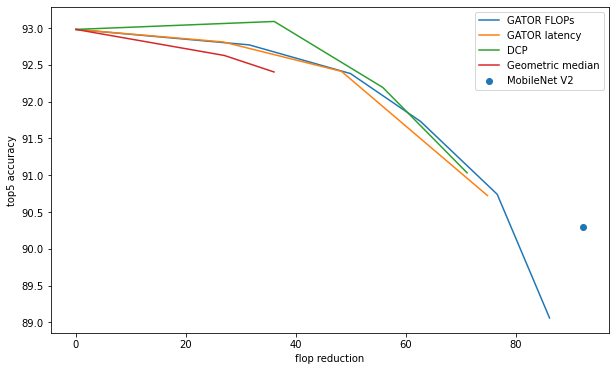

In [34]:
plot_comparison('flop_reduction', 'top5', True)

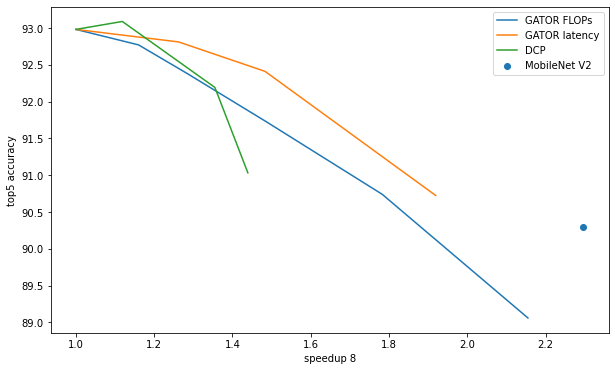

In [35]:
plot_comparison('speedup 8', 'top5', True)

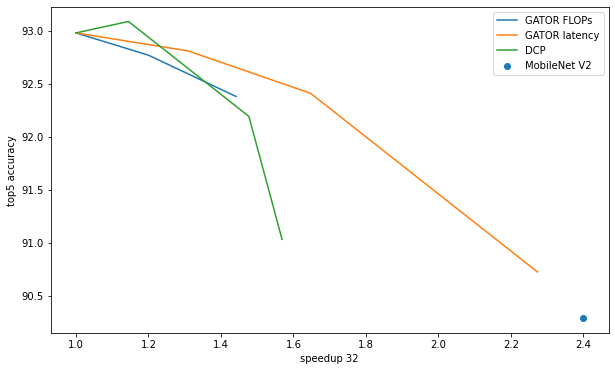

In [36]:
plot_comparison('speedup 32', 'top5', True)